# Dimensionality Reduction and Generative Modelling

## Introduction to Variational Autoencoder

Variational autoencoder (VAE, [Kingma and Welling,2013](https://arxiv.org/abs/1312.6114)) is a generative model. Like an autoencoder, the VAE projects input data into a latent space and then tries to reconstruct the original data back from the latent space representation. But instead of mapping the data to a single point in the embedding space (now we will refer to this as the *latent space*) it maps it to a distribution. 

In VAE, we map each datapoint to a mean and standard deviation of a multivariate Gaussian (the number of dimensions of this Gaussian is the dimension of our latent space). Now, to get a re-construction, we sample from the latent distribution and project the sample back into the original data space (to the space of MNIST images, in our case). 

The architecture of a simple VAE model to be implemented as part of this exercise is shown below. Blocks used to construct the cost function are shown in blue color. (Refer to this [tutorial](https://arxiv.org/abs/1606.05908) for more details) 

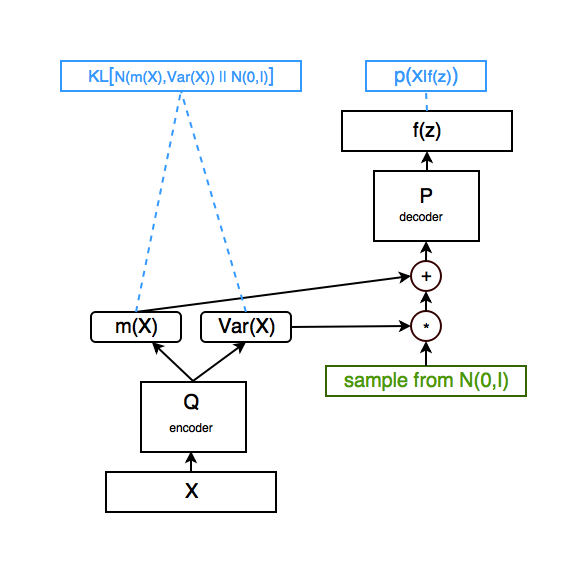

In [1]:
from IPython.display import Image
Image(filename='vae.png',height=150,width=500)

In contrast to the neural network methods we have seen previously, VAE takes Variational Inference approach for learning from the data. As shown during the lecture, using Variational Inference approach, for an observation matrix $\mathbf{X}$ and corresponding latent space representation $\mathbf{z}$, we can arrive at a lower bound for marginal likelihood as :

$$
    \begin{split}
        \log p(\mathbf{X}) &\ge \mathbb{E}_{\mathbf{z} \sim q(\mathbf{z}|\mathbf{X})}\left[\log p(\mathbf{X}|f(\mathbf{z}))\right] \: - KL\left[q(\mathbf{z|X}) || p(\mathbf{z}) \right] \\
\text{}\\
\text{Where,} \\
        q(\mathbf{z|X}) &= \mathcal{N}(\mathbf{z}|\mu(\mathbf{X}),\Sigma(\mathbf{X})) \:\:\: \text{is the variational posterior distribution}\\
        p(\mathbf{z}) &= \mathcal{N}(\mathbf{z}|\textbf{0},\textbf{I}) \:\:\: \text{is the prior distribution}\\
        \\
        p(\mathbf{X}|f(\mathbf{z})) &: \text{likelihood function}\\ 
        \\
        \mu(\mathbf{X}) &: \text{a function mapping from data space to latent space}\\
        \Sigma(\mathbf{X}) &: \text{a function mapping from data space to latent space}\\
        f(\mathbf{z}) &: \text{a function mapping from latent space to data space}
\end{split}
$$  

By maximizing the above lower bound on the marginal likelihood, the model tries to learn parameters of the variational distribution (encoder mapping through a feed-forward network) and the reconstruction (decoder mapping again as a feed-forward network). 

So the lower bound can be seen as a sum of two terms:
  1. The reconstruction term 
  2. The KL divergence term 
  
The intuition behind the first term can thought of learning the data fit, that is, given $\mathbf{z}$ the model learns a mapping to match the given data. However, the expectation part cannot be analytically solved, instead, we take samples from $q(\mathbf{z|X})$ and consider average of $p(\mathbf{X}|f(\mathbf{z}))$ over these samples as an approximation for the expectation. (in this exercise we will be taking only one sample)

The second term, the KL term, tries to penalize deviation of variational distribution from the prior. 
(we could still train the model without the KL part, would there be any issues then?)



## Task 01. KL divergence derivation (2 points)

The key difference in the cost function between normal autoencoder and VAE is the KL term. The following section deals with deriving this term for the model under consideration, and understanding the intuition behind it. 

Kullback-Leibler divergence can be interpreted as a measure of "distance" between two distributions. However, it is not a metric, that is, $\operatorname{D_{KL}}(q||p) \ne \operatorname{D_{KL}}(p||q)$. Read more in this [post](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) for a good introduction to KL divergence.

Formally it is defined as below:
$$
    \begin{split}
        \operatorname{D_{KL}}(q(x)||p(x)) &= \int q(x) \log \frac{q(x)}{p(x)} dx\\
        &= \underbrace{\int q(x) \log q(x) dx}_{\text{negative entropy}} - \underbrace{\int q(x) \log p(x) dx}_{\text{cross-entropy}}
\end{split}
$$

In the current model, second term in the lower bound defines the KL divergence between two diagonal multivariate Gaussians : a prior distribution $p(\mathbf{z})$ and a variational posterior $q(\mathbf{z})$ (i.e. latent dimensions are assumed to be independent).
$$
    \begin{split}
        \operatorname{D_{KL}}(q(\mathbf{z|X})||p(\mathbf{z})) &= \underbrace{\int q(\mathbf{z|X}) \log q(\mathbf{z|X}) d\mathbf{z}}_{\text{A}} - \underbrace{\int q(\mathbf{z|X}) \log p(\mathbf{z}) d\mathbf{z}}_{\text{B}}
\end{split}
$$

The derivation of the entropy part is given below, and your task would be to complete the derivation for the cross-entropy part.

**Entropy derivation:**<br>
Let $q(\mathbf{z|X})$ be a $J$ dimensional Gaussian random variable with mean $\mu(\mathbf{X})$ and diagonal covariance $\Sigma(\mathbf{X)}$. In order to simplify notations, lets denote them as $\boldsymbol{\mu}$ and $\boldsymbol{\Sigma}$ respectively. <br>
Because of the diagonal covariance structure, the density can be factorized as below.
$$
\begin{split}
q(\mathbf{z}) &= \prod_{j=1}^J \mathcal{N}\left(z_j \:|\: \mu_j,\Sigma_{(j,j)}\right)\\
&= \prod_{j=1}^J \mathcal{N}(z_j | \mu_j,\sigma_j^2)
\end{split}
$$
Where $\mathcal{N}(z_j | \mu_j,\sigma_j^2)$ represents a univariate Gaussian with mean $\mu_j$ and variance $\sigma_j^2$ respectively.

The entropy term can thus be written as:
$$
    \begin{split}
        A &= \int \mathcal{N}(\mathbf{z}\:|\:\boldsymbol{\mu},\boldsymbol{\Sigma}) \log \mathcal{N}(\mathbf{z}\:|\:\boldsymbol{\mu},\boldsymbol{\Sigma}) \: d\mathbf{z}\\
        &= \int \prod_{j=1}^J \mathcal{N}(z_j | \mu_j,\sigma_j^2) \: \log \prod_{j=1}^J \mathcal{N}(z_j | \mu_j,\sigma_j^2) \: d z_j\\
        &= \sum_{j=1}^J \int \mathcal{N}(z_j | \mu_j,\sigma_j^2) \: \log \mathcal{N}(z_j | \mu_j,\sigma_j^2) \: d z_j \\
        &= \sum_{j=1}^J \mathbb{E}_{z_j \sim \mathcal{N}(\mu_j,\sigma_j^2)} \: \log \left( \frac{1}{\sqrt{2\pi \sigma_j^2}} e ^{- \frac{(z_j - \mu_j)^2}{2 \sigma_j^2} } \right) \\
        &= \sum_{j=1}^J - \frac{1}{2} \left[ \log 2\pi + 2 \log \sigma_j + \frac{1}{\sigma_j^2} \mathbb{E}_{z_j \sim \mathcal{N}(\mu_j,\sigma_j^2)} (z_j - \mu_j)^2 \right] \\
        &= \sum_{j=1}^J - \frac{1}{2} \left[ \log 2\pi + 2 \log \sigma_j + \frac{1}{\sigma_j^2} \left(\sigma_j^2\right) \right]\\
        &= \sum_{j=1}^J - \frac{1}{2} \left[ \log 2\pi + 2 \log \sigma_j + 1 \right]
\end{split}
$$

Where we used the fact that expectation is a linear operator and $\mathbb{E}_{x \sim \mathcal{N}(\mu,\sigma^2)} [\: (x-\mu)^2 \:] = \sigma^2$

**Cross-entropy derivation:**<br>
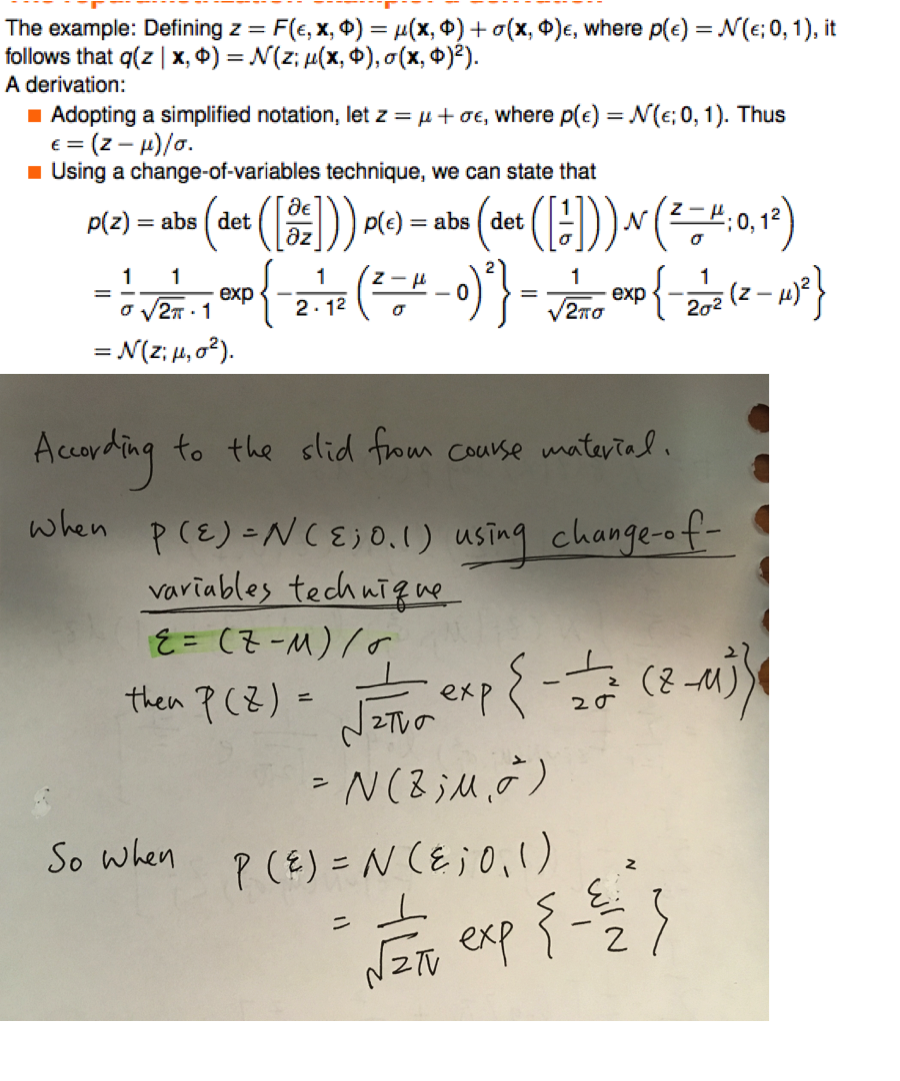
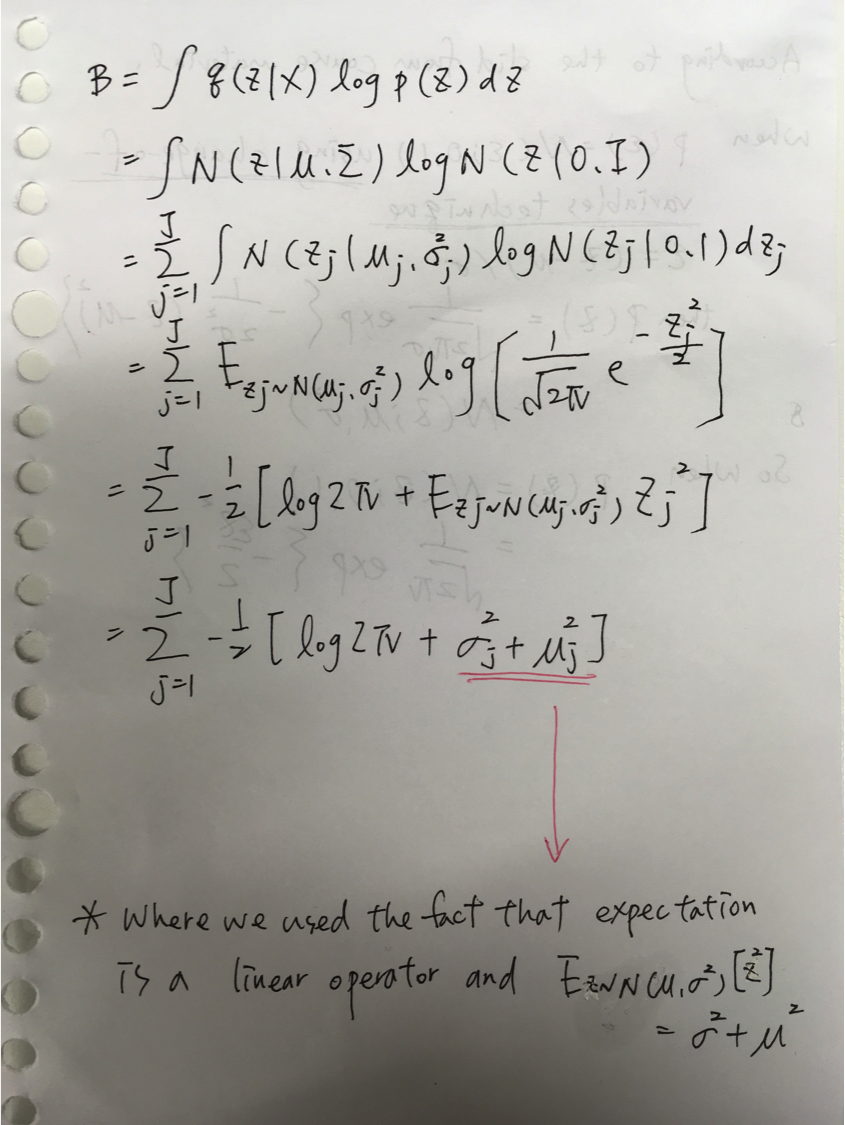

Derivations can be returned in 2 ways:

1. You can type in the derivation in $\LaTeX$
2. Alternatively you can write the derivation by some other means and provide the image of it (screenshot or photograph) below

(for adding a local image use the code: Image(filename='image_name.png',height=1000,width=500))

************
.
.
.
.
add the derivation here in $\LaTeX$ or replace with code to load the image
.
.
.
.
************

**Combined KL:**

Combining above results for entropy and cross-entropy terms, the KL term can be written as :
$$
    \begin{split}
        \operatorname{D_{KL}}(q(\mathbf{z|X})||p(\mathbf{z})) &= A - B \\
        &= \sum_{j=1}^J -\frac{1}{2}\left[2 \log \sigma_j + 1 - (\mu_j^2 + \sigma_j^2)  \right]\\
        &= -\frac{1}{2} \sum_{j=1}^J \left[1+ \log \sigma_j^2 - \mu_j^2 - \sigma_j^2)  \right]\\
\end{split}
$$

**Final lower bound**:

In this exercise, since we consider MNIST digits as binary variables, the likelihood distribution $p(\mathbf{x}|f(\mathbf{z}))$ is assumed to be Bernoulli distribution. We also assume that all the data dimensions are independent. Thus the complete log likelihood with Bernoulli observations can be written as:
$$
\begin{split}
     \log p(\mathbf{X}|f(\mathbf{z})) &= \log \prod_{n=1}^{N} \prod_{d=1}^{D} p(x_{(n,d)}|f(z)_{(n,d)})\\
     &= \sum_{n=1}^{N}\sum_{d=1}^{D} \log \: p(x_{(n,d)}|f(z)_{(n,d)})\\
     &= \sum_{n=1}^{N}\sum_{d=1}^{D} \log \: f(z)_{(n,d)}^{x_{(n,d)}} + (1-f(z)_{(n,d)})^{(1-x_{(n,d)})}\\
     &= \sum_{n=1}^{N}\sum_{d=1}^{D} ( x_{(n,d)} \cdot \log f(z)_{(n,d)}) + ((1-x_{(n,d)}) \cdot \log (1-f(z)_{(n,d)}))
\end{split}
$$
Where $N$ is the number of observations, $J$ is the number of latent dimensions, $D$ is the number of dimensions for each observation. Indexes along these dimensions are represented by lower case letters.<br>


Earlier, we had derived analytical form of KL divergence for the model under consideration (for each observation). Finally, by combining the likelihood and KL part across all the observations, we can arrive at the lower bound as:
$$
\begin{split}
     \log p(\mathbf{X}) &\ge \sum_{n=1}^{N} \left\{ \sum_{d=1}^D \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\boldsymbol{\mu(\mathbf{x}_{(n:)})},\Sigma(\mathbf{x}_{(n:)})} \left[ \log p(x_{(n,d)}|f(z)_{(n,d)}) \right] \: + \: \sum_{j=1}^J \frac{1}{2} \left[1+ \log \sigma_{(n,j)}^2 - \mu_{(n,j)}^2 - \sigma_{(n,j)}^2)  \right] \right\}\\
\text{}\\
\text{Where,}\\
    &\mu_{(n,j)}, \sigma_{(n,j)}^2 \: \text{are mean and variance of $j^{th}$ latent dimension for $n^{th}$ observation}\\
    &\mathbf{X} \text{ represents observation matrix, $\mathbf{x}_{(n:)}$ the $n^{th}$ observation vector and $x_{(n,d)}$ the corresponding scalar value on $d^{th}$ dimension}
    \end{split}
$$  


**Drawing samples from the VAE:**

Recall that the VAE is a generative model, so we must be able to draw samples from it. Minimizing the 'overlap' term in the VAE cost allows us to approximate a complex posterior to a diagonal multivariate normal. After training the VAE, we should then be able to sample from the prior and project them to data space to get samples of (in this case) MNIST images. So, we have a generative model !

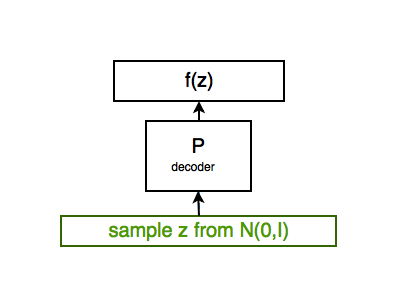

In [2]:
from IPython.display import Image
Image(filename='vae_sampling.png',height=100,width=400)

## 02. Implementation (3 points)

Now that we have an intuitive understanding of the VAE, let's implement it. Note that VAE takes quite a lot of iteration to get trained with computational resources accessible for the assignments (over 500 epochs on full training dataset with 500 mini-batch size). 

The expectation from the home assignment is to understand and implement generative models, not to train the model completely. For implementation, choose the training size, mini-batch size and training parameters such that computation resources can be effectively utilized. Training size of 5k observations with mini-batch size = 50 and Adam learning rate = 0.001 might be good values to begin with.

After successful completion of the implementation, run the model for at least 20 epochs and plot mean training and mean validation costs across iterations. 

This part of the assignment will carry 2 points. A correct implementation will be the one for which mean cost goes down to $\approx$ 200 for reasonable hyperparameter initializations.

Note: Retain the symbolic variable names as given below. For the discussion part, pre-trained weights will be given and it needs all the Theano variables named as given below.

** Libraries and dataset imports**

In [3]:
# theano imports
import theano
import numpy as np
import theano
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

# plotting functionalities
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# load pretained objects
import six.moves.cPickle as pickle

# helper functions
from exercise_helper import load_data,gradient_updates_Adam
from exercise_helper import plot_2d_proj,plot_act_rec,plot_latent_space2D
from exercise_helper import plot_img, plot_activations

theano.config.floatX = "float32"

# random number generators
rng_np = np.random.RandomState(23455)
srng = RandomStreams(seed=1234)

In [4]:
# change the train_size to take subsets of the data
datasets = load_data('mnist.pkl.gz', train_size = 5000,binarize="stochastic")
train_x, train_y = datasets[0]
valid_x, valid_y = datasets[1]
test_x, test_y   = datasets[2]
print(train_x.shape)

***** Loading data *****
Shape.0


** Model implementation**

In [135]:
# implementing the VAE in theano
# similar network architecture to (Kingma and Welling 2013)

# symbolic variable declaration
input = T.matrix("input") # observation matrix as input 
learning_rate = T.scalar("learning_rate") # learning rate for the optimizer
mbidxs = T.lvector("mbidxs") # mini-batch index



###################################################################
###################### INSERT YOUR CODE HERE ######################
###################################################################

# define number of latent dimensions 
# use 2 latent dimensions for the implementation
latent_dim = 2
# a list of layer dimensions
dims = [784, 500, latent_dim, 500, 784]



# ------------------------------------------------------
# parameter initializations 
# ------------------------------------------------------

# Use Glorot and Bengio (2010) initialization for weights
# initialize weights for input to hidden layer
# size : (dims[0],dims[1])
uniform_lim = lambda n_in,n_out : (-np.sqrt(6.0/(n_in+n_out)), np.sqrt(6.0/(n_in+n_out))) 
W1 = theano.shared(rng_np.uniform(*uniform_lim(dims[0], dims[1]), size=dims[0:2]), borrow=True, name="W1") # n_in = 784, n_out = 300
#W2 = theano.shared(rng_np.uniform(*uniform_lim(dims[1], dims[2]), size=dims[1:3]), borrow=True, name="W2") # n_in = 300, n_out = 2
#W3 = theano.shared(rng_np.uniform(*uniform_lim(dims[2], dims[3]), size=dims[2:4]), borrow=True, name="W3") # n_in = 2, n_out = 300
#W4 = theano.shared(rng_np.uniform(*uniform_lim(dims[3], dims[4]), size=dims[3:5]), borrow=True, name="W4") # n_in = 300, n_out = 784
# initialize weights for hidden to latent layer (mean)
# size : (dims[1],dims[2])
W2_mu = theano.shared(rng_np.uniform(*uniform_lim(dims[1], dims[2]), size=dims[1:3]), borrow=True, name="W2_mu") # n_in = 300, n_out = 2



# initialize weights for hidden to latent layer (log variance)
# size : (dims[1],dims[2])
# note that in order to make variance parameter unconstrained
# we choose to model log(variacne) instead of variance
W2_logvar = theano.shared(rng_np.uniform(*uniform_lim(dims[1], dims[2]), size=dims[1:3]), borrow=True, name="W2_logvar") # n_in = 300, n_out = 2

# initialize weights for latent layer (z) to second hidden layer 
# size : (dims[2],dims[3])
W3 = theano.shared(rng_np.uniform(*uniform_lim(dims[2], dims[3]), size=dims[2:4]), borrow=True, name="W3") # n_in = 2, n_out = 300

# initilize weights from second hidden layer to output layer f(z)
# size : (dims[3],dims[4])
W4 = theano.shared(rng_np.uniform(*uniform_lim(dims[3], dims[4]), size=dims[3:5]), borrow=True, name="W4") # n_in = 300, n_out = 784

# initialize bias for first hidden layer
# size : (dims[1],) 
b1 = theano.shared(np.zeros((dims[1],)), borrow=True, name="b1")
#b2 = theano.shared(np.zeros((dims[2],)), borrow=True, name="b2")
#b3 = theano.shared(np.zeros((dims[3],)), borrow=True, name="b3")
#b4 = theano.shared(np.zeros((dims[4],)), borrow=True, name="b4")

# initialize bias for latent layer (mean)
# size : (dims[2],)
b2_mu = theano.shared(np.zeros((dims[2],)), borrow=True, name="b2_mu")

# initialize bias for latent layer (log variance)
# size : (dims[2],)
b2_logvar = theano.shared(np.zeros((dims[2],)), borrow=True, name="b2_logvar")

# initialize bias for the second hidden layer
# size : (dims[3],)
b3 = theano.shared(np.zeros((dims[3],)), borrow=True, name="b3")

# initialize bias for the output layer 
# size : (dims[4],) 
b4 = theano.shared(np.zeros((dims[4],)), borrow=True, name="b4")


# ------------------------------------------------------
# define feed-forward computations
# ------------------------------------------------------
relu = T.nnet.relu
tanh = T.tanh
sigmoid = T.nnet.sigmoid
# compute non-linear activations in the first hidden layer
# hint : use input, W1, and b1
_input  = srng.binomial(n=1, p=0.95, size=input.shape) # add some random noise at the input layer
x1     = tanh(T.dot(input*_input, W1) + b1)

# compute linear activation for latent mean
# hint : use x1, W2_mu, b2_mu
mu     = T.dot(x1, W2_mu) + b2_mu

# compute linear activation for latent logvar
# hint : use x1, W2_logvar, b2_logvar
logvar = T.dot(x1, W2_logvar) + b2_logvar


# compute z
# z = mu + {exp(0.5*logvar) * rnd_sample}
# where rnd_sample is from standard normal
# hint : pick samples of size (num_observation,dims[2])
# hint : use srng for reproducibility
rnd_sample = srng.normal(size=(input.shape[0], dims[2]))
z      = mu + (T.exp(0.5*logvar) * rnd_sample)

# compute non-linear activation at second hidden layer
# hint: use z, W3, b3
x1_rec = tanh(T.dot(z, W3) + b3)

# compute networks ouputs f(z)
# hint : add non-linearity to scale output btw 0-1
# hint : use x_rec, W4, b4
x_rec  = sigmoid(T.dot(x1_rec, W4) + b4)


# ------------------------------------------------------
# back propagation computations
# ------------------------------------------------------

# compute lower_bound = reconstruction cost - KL cost
# minimie negative of lower bound i.e. cost = -lower_bound

# hint reconstruction cost for each observation 
# can be computed as sum of binary cross entropy 
# across all dimensions 
cost_rec = T.sum(input * T.log(x_rec) + (1-input) * T.log(1-x_rec))
#print(cost_rec.eval({input:train_x[0:2],}).shape)
#cost_rec = -T.sum(input * T.log(x_rec) + (1-input) * T.log(1-x_rec)) 
#cost_entropy = -T.mean(input * T.log(input) + (1-input) * T.log(1-input)) 
# hint KL cost for each observation 
# can be computed using the formula given above
cost_KL  = -0.5*T.sum(1+logvar-mu**2-T.exp(logvar))

# compute lower bound for each observation
# as reconstruction - kl cost
lower_bound = cost_rec - cost_KL

# final cost function scalar to minimize
# can be computed as negative mean of lower bound
cost = -lower_bound.mean()



# create a list of all the parameters to be optimized
params = [W1,W2_mu,W2_logvar,W3,W4,b1,b2_mu,b2_logvar,b3,b4]


# pass cost and params list to 
# gradient_updates_Adam for optimization
# above function returns updates list for training
# refer to assignment3 for more details
updates = gradient_updates_Adam(cost,params,learning_rate,eps = 1e-8,beta1 = 0.9,beta2 = 0.99)


# ------------------------------------------------------
# define theano functions
# ------------------------------------------------------


# define vae_train function 
# inputs : minibatch-index and learning rate
# ouputs : cost, cost_rec and cost_KL
# updates: updates from Adam
# givens : symobolic input as subset of 
#        : train_x over minibatch index
vae_train = theano.function(
        inputs = [mbidxs, learning_rate],
        outputs = [cost, cost_rec, cost_KL],
        updates = updates,
        givens = {input : train_x[mbidxs,:],}
    )

# define vae_cost function
# inputs : input observation matrix
# outputs: cost, cost_rec and cost_KL
vae_cost = theano.function(
        inputs = [input],
        outputs = [cost, cost_rec, cost_KL] 
    )

# define vae_predict function
# inputs : input observation matrix
# outputs: f(z), latent mu and logvar
vae_predict = theano.function(
        inputs = [input],
        outputs = [x_rec, mu, logvar] 
    )


# define vae_generate function
# inputs : input z
# outputs: f(z) or output of the final layer
vae_generate = theano.function(
        inputs = [z],
        outputs = x_rec 
    )

# define vae_z function
# inputs : input observations
# outputs: z or latent space for the input
vae_z = theano.function(
        inputs = [input],
        outputs = z 
    )



###################################################################
############################ END ##################################
###################################################################


In [136]:
# define training parameters
mb_size = 50
epochs = 20
lrate = 0.001
train_costs = []
valid_costs = []
train_start_time = time.time()

train_size    = len(train_y.eval()) 
training_idxs = np.arange(train_size)

print("***** training started  *****")
for epoch in range(epochs):
    
    rng_np.shuffle(training_idxs)
                
    try:    
        # initialize empty lists to collect costs
        t_minib_costs = []
        t_minib_cost_kl = []
        t_minib_cost_rec = []
        start_time = time.time()
        
        for batch_startidx in range(0, train_size, mb_size):

            mini_batch = training_idxs[batch_startidx:batch_startidx+mb_size]
            
            # MODEL TRAINING CALL
            mb_train_cost, mb_cost_rec,mb_cost_kl  = vae_train(
                    mbidxs = np.asarray(mini_batch).astype(np.int32),
                    learning_rate=lrate)
            
            # collect costs
            t_minib_costs.append(np.mean(mb_train_cost))
            t_minib_cost_kl.append(np.mean(mb_cost_kl))
            t_minib_cost_rec.append(np.mean(mb_cost_rec))
            
            
        valid_cost, _, _ = vae_cost(input = valid_x.get_value())
        
        train_costs.append(np.mean(t_minib_costs))
        valid_costs.append(np.mean(valid_cost))
        
        print("epoch={:<3d} -- train_cost={:>6.4f} -- valid_cost={:>6.4f} -- cost(Rec,KL)=({:>6.4f},{:>6.4f}) -- time={:>5.3f}".format(epoch+1, train_costs[-1], valid_costs[-1], np.mean(t_minib_cost_rec),np.mean(t_minib_cost_kl),time.time()-start_time))    
    
    except KeyboardInterrupt as e:
        print("***** stopping *****")
        break

***** training started  *****
epoch=1   -- train_cost=13956.0629 -- valid_cost=355722.7557 -- cost(Rec,KL)=(-12883.1741,1072.8888) -- time=3.578
epoch=2   -- train_cost=10371.1891 -- valid_cost=335132.5139 -- cost(Rec,KL)=(-9915.0242,456.1648) -- time=3.507
epoch=3   -- train_cost=10086.1991 -- valid_cost=348718.1041 -- cost(Rec,KL)=(-9762.6368,323.5623) -- time=3.108
epoch=4   -- train_cost=9953.6516 -- valid_cost=332922.1809 -- cost(Rec,KL)=(-9661.5043,292.1473) -- time=2.871
epoch=5   -- train_cost=9869.1754 -- valid_cost=322867.8648 -- cost(Rec,KL)=(-9614.0443,255.1311) -- time=2.888
epoch=6   -- train_cost=9761.7030 -- valid_cost=323242.1340 -- cost(Rec,KL)=(-9522.3516,239.3514) -- time=3.044
epoch=7   -- train_cost=9485.0780 -- valid_cost=306273.6204 -- cost(Rec,KL)=(-9248.7471,236.3309) -- time=3.438
epoch=8   -- train_cost=9385.6477 -- valid_cost=305215.1134 -- cost(Rec,KL)=(-9141.6254,244.0223) -- time=2.964
epoch=9   -- train_cost=9236.7214 -- valid_cost=300461.8911 -- cost(R

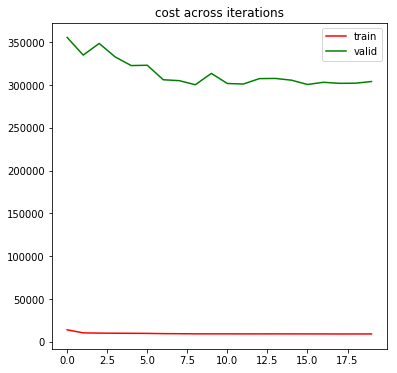

In [137]:
# plot training & validation cost across iterations
plt.plot(range(len(train_costs)), train_costs, "r", label="train")
plt.plot(range(len(valid_costs)), valid_costs, "g", label="valid")
plt.title("cost across iterations")
plt.legend()
plt.show()

By now, the training and validation cost across iterations should have started going down. However, model might not be trained enough. In the following blocks, latent space and reconstructions are visualized. Don't panic if all reconstructions look like blurry eggs. Model has not been trained enough.

The latent space can be visualized as shown in the plot below. Location of each ellipse is determined by the mean value $\mu(\mathbf{x})$ and width is determined by value of the standard deviation corresponding to the variance $\Sigma\mathbf{(x)}$ for each observation. 

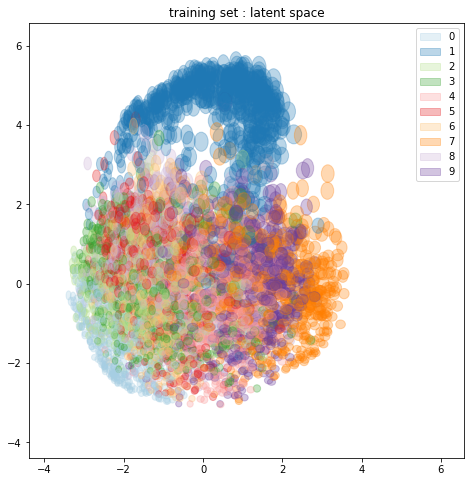

In [138]:
rec, latent_mu,latent_logvar = vae_predict(train_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,train_y.eval(),"training set : latent space")

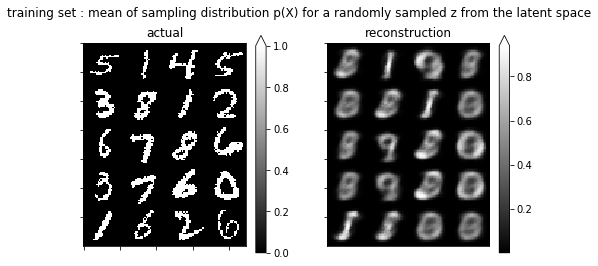

In [139]:
actual = train_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"training set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

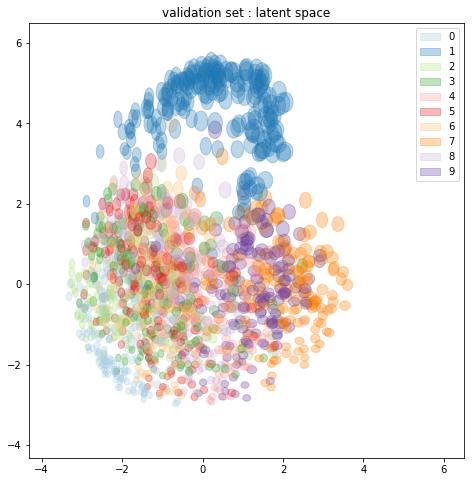

In [140]:
rec, latent_mu, latent_logvar = vae_predict(valid_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,valid_y.eval(),"validation set : latent space")

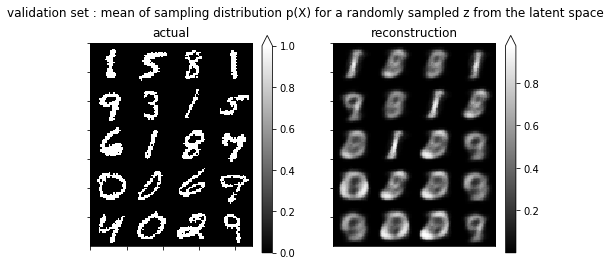

In [141]:
actual = valid_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"validation set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

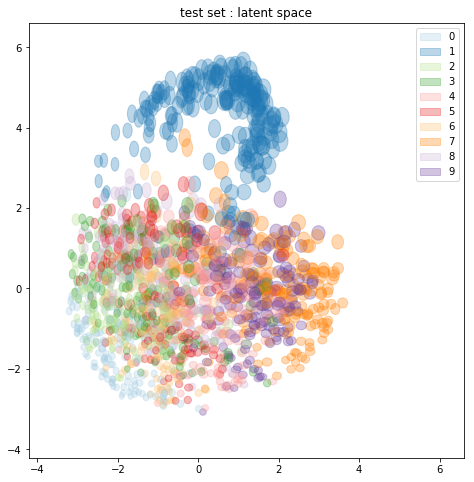

In [142]:
rec, latent_mu,latent_logvar = vae_predict(test_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,test_y.eval(),"test set : latent space")

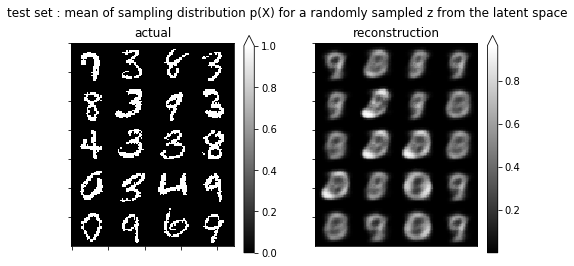

In [143]:
actual = test_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"test set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

Now we generate mean of the data sampling distribution $p(\mathbf{x})$ by drawing random latent samples from the prior $p(\mathbf{z})$ and then passing it through the decoder. 

Note that these are not yet data samples, but rather means of $p(\mathbf{x})$ for each observation. In order to generate true data samples, one will have to take Bernoulli samples from this sampling distribution.

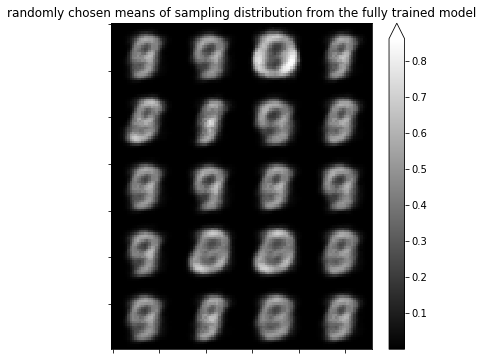

In [144]:
rand_data = np.random.normal(size=(20,2)).astype(np.float32)
samples = vae_generate(rand_data)

plot_img(samples,
            name="randomly chosen means of sampling distribution from the fully trained model")

Now we generate samples from the visualize them on a 2D grid. *plot_sample_2d* take samples uniformly on a 2D grid for the latent space $\mathbf{z}$, and generates network constructions for these samples.


Note that *sample_latent* is used only to *check min & max range for latent dimensions* within which the grid samples are generated.

In [145]:
def plot_sample_2d(sample_latent,name=None):
    matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
    min_z = np.min(sample_latent,axis=0)
    max_z = np.max(sample_latent,axis=0)

    idx = np.arange(min_z.shape[0]);
    np.random.shuffle(idx)
    ld_idx = idx[:2]
    minz = min_z[ld_idx]
    maxz = max_z[ld_idx]

    img = np.zeros((28*20, 28*20))
    zvals_1 = np.linspace(minz[0], maxz[0], 20)
    zvals_2 = np.linspace(minz[1], maxz[1], 20)
    for i, z1 in enumerate(zvals_1):
        for j, z2 in enumerate(zvals_2):
            z_sample = np.zeros(sample_latent[0].shape)
            np.put(z_sample,ld_idx,[z1,z2])
            xp = vae_generate([z_sample])
            img[(i*28):((i+1)*28), (j*28):((j+1)*28)] = xp.reshape((28, 28))

    fig,ax = plt.subplots()
    im = ax.imshow(img,cmap='gray')
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    if name is not None:
        ax.set_title(name)
    plt.show()

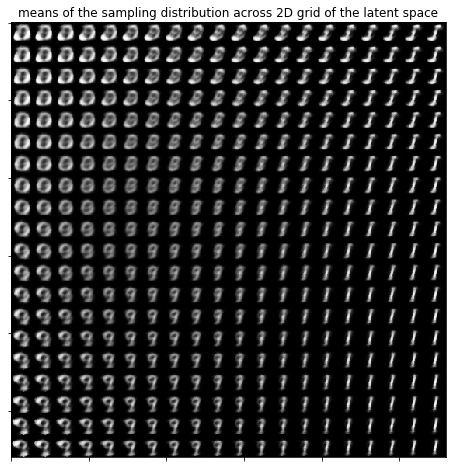

In [146]:
sample_latent = vae_z(test_x.get_value())
plot_sample_2d(sample_latent,name="means of the sampling distribution across 2D grid of the latent space")

** Pre-trained model**

In the following section, Theano shared variables for all the weights and biases are initialized with pre-trained weights. Above model was trained with all 50k training samples for 500 epochs with 500 mini-batch size. Adam optimizer was used with learning rate = 0.0001 (and default value for other Adam parameters).

In [147]:
# loading pre-trained weights
f = open('pretrained/vae_2ld.save', 'rb')
pretrained_weights = pickle.load(f)
f.close()

In [148]:
# load pre-trained weights and biases
W1.set_value(pretrained_weights['W1'])
W2_mu.set_value(pretrained_weights['W2_mu'])
W2_logvar.set_value(pretrained_weights['W2_logvar'])
W3.set_value(pretrained_weights['W3'])
W4.set_value(pretrained_weights['W4'])
b1.set_value(pretrained_weights['b1'])
b2_mu.set_value(pretrained_weights['b2_mu'])
b2_logvar.set_value(pretrained_weights['b2_logvar'])
b3.set_value(pretrained_weights['b3'])
b4.set_value(pretrained_weights['b4'])

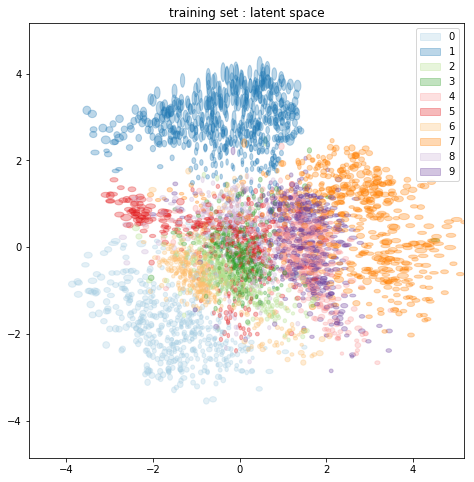

In [149]:
rec, latent_mu,latent_logvar = vae_predict(train_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,train_y.eval(),"training set : latent space")

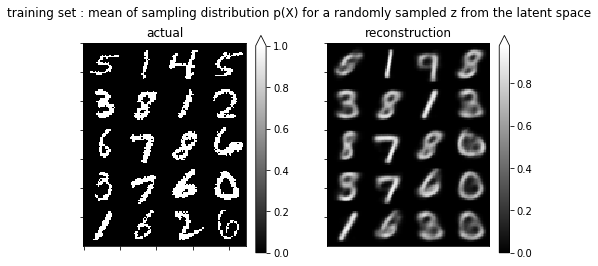

In [150]:
actual = train_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"training set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

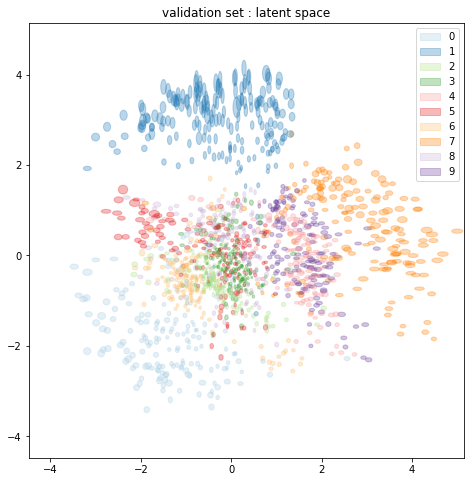

In [151]:
rec, latent_mu, latent_logvar = vae_predict(valid_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,valid_y.eval(),"validation set : latent space")

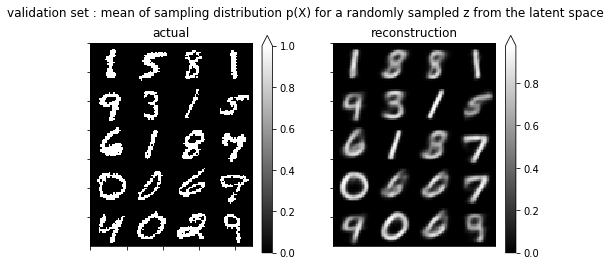

In [152]:
actual = valid_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"validation set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

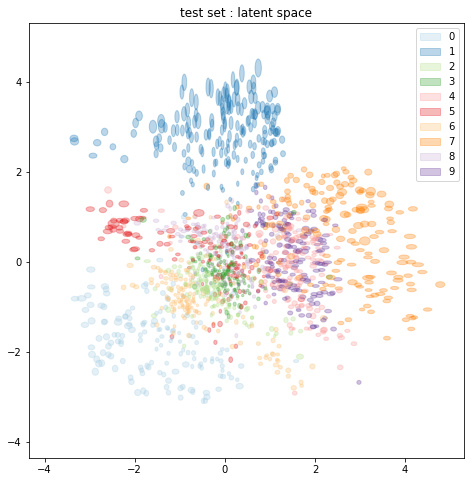

In [153]:
rec, latent_mu,latent_logvar = vae_predict(test_x.get_value())
plot_latent_space2D(latent_mu,latent_logvar,test_y.eval(),"test set : latent space")

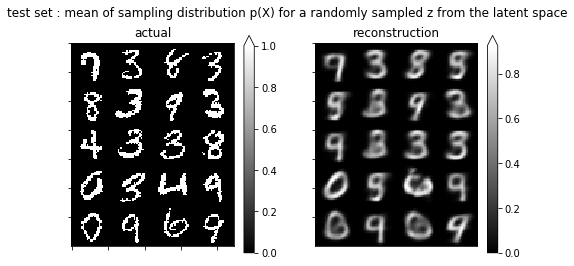

In [154]:
actual = test_x.get_value()[:20,:]
recons,_,_ = vae_predict(actual)
plot_act_rec(actual,recons,"test set : mean of sampling distribution p(X) for a randomly sampled z from the latent space")

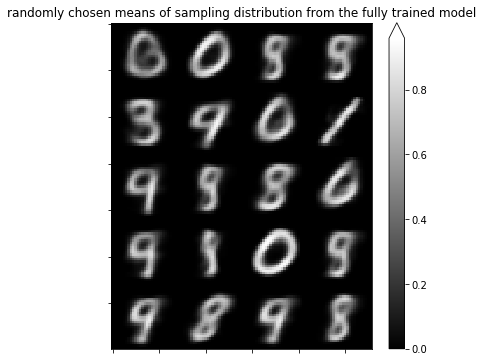

In [155]:
rand_data = np.random.normal(size=(20,2)).astype(np.float32)
samples = vae_generate(rand_data)

plot_img(samples,
            name="randomly chosen means of sampling distribution from the fully trained model")

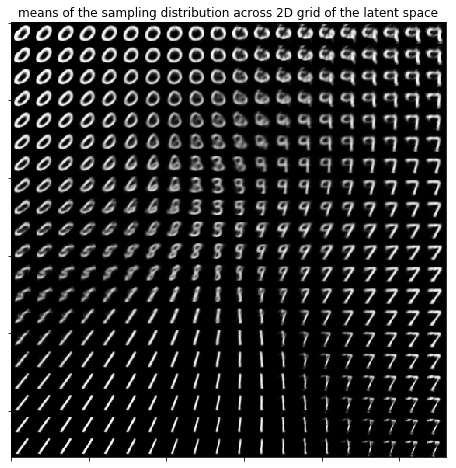

In [156]:
sample_latent = vae_z(test_x.get_value())
plot_sample_2d(sample_latent,name="means of the sampling distribution across 2D grid of the latent space")

## Task 3. Discussion (1 point)

Q: By looking at the actual vs reconstructed plots which digits you think the models learned to reconstruct well?

ANS: For my result, I think the number of 0, 1, and 7 has better reconstruct result.

Q: Are there any interesting observations on the latent space?

ANS: In the latent space, number 0, 1 and 7 are separated from the other color obviously.

Q: Can reconstruction quality be understood by looking at posterior mean and variance? 

ANS: According to the variational autoencode and reconstructed plot that generate by this assignment, as the reconstruction is generated by the posterior mean and variance so, to discuss with the Univariate Gaussian, as reconstruction is cross-entropy and posterior mean and variance can generate the entropy, to reference the equation in the assignment, the quality of the cross-entropy can be understood by the posterior mean and variance

Q: How can the sampling distribution plot on the 2D grid be connected to the above discussion?

ANS: According to the 2D grid, we still can recognize the number of 0, 1 and 7, and the result is as same as the reconstructed plots and latent space.
